# Neural Network Project (2)
# Human Activity Recognition with LSTM using the WISDM Dataset

This project demonstrates how to use an LSTM neural network to classify human activities based on smartphone accelerometer data from the WISDM dataset.

# Importing Necessary Libraries

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Reading the data, preprocessing and feature engineering to prepare data for LSTM Model.

In [77]:
column_names = ['user', 'activity', 'timestamp', 'x', 'y', 'z']

# Read while skipping bad lines and stripping the trailing semicolon
df = pd.read_csv('WISDM_ar_v1.1_raw.txt',
                 header=None,
                 names=column_names,
                 on_bad_lines='skip')

# Clean the 'z' column (remove semicolon and convert to float)
df['z'] = df['z'].astype(str).str.replace(';', '', regex=False)
df['z'] = df['z'].astype(float)

print(df.head())



   user activity       timestamp         x          y         z
0    33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1    33  Jogging  49106062271000  5.012288  11.264028  0.953424
2    33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3    33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4    33  Jogging  49106332290000 -1.184970  12.108489  7.205164


In [78]:
# Creating New Feature (Acceleration Magnitude) as it Gives a compact representation of overall motion intensity — great for distinguishing still vs active movements.
df['accel_mag'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)

In [79]:
df.head()

,user,activity,timestamp,x,y,z,accel_mag
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,12.709551
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,12.365693
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,11.936562
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,18.751973
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,14.139804


In [80]:
df.shape

(1086466, 7)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086466 entries, 0 to 1086465
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1086466 non-null  int64  
 1   activity   1086466 non-null  object 
 2   timestamp  1086466 non-null  int64  
 3   x          1086466 non-null  float64
 4   y          1086466 non-null  float64
 5   z          1086465 non-null  float64
 6   accel_mag  1086465 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 58.0+ MB


In [82]:
# Checking for null Values.
df.isnull().sum()

,0
user,0
activity,0
timestamp,0
x,0
y,0
z,1
accel_mag,1


In [83]:
df = df.dropna()

In [84]:
df.isnull().sum()

,0
user,0
activity,0
timestamp,0
x,0
y,0
z,0
accel_mag,0


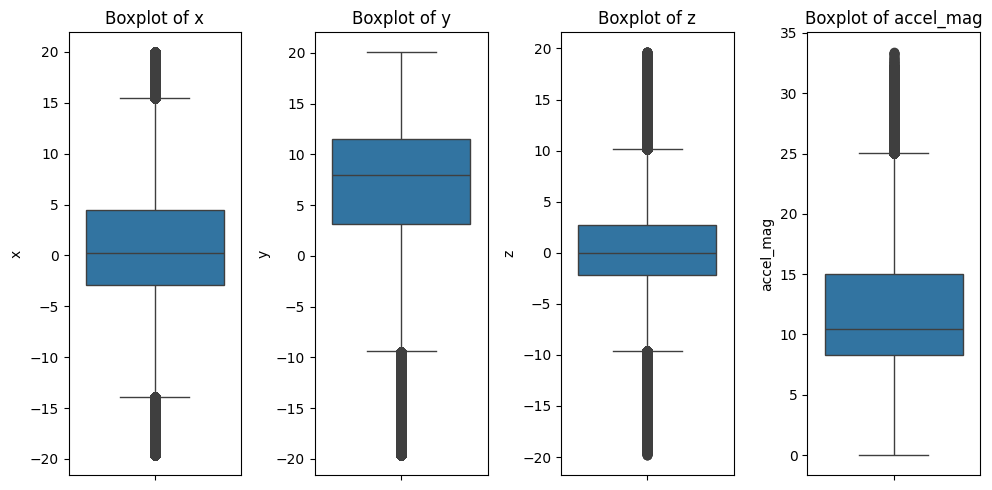

In [85]:
# checking for outliers in numerical features
columns = ['x', 'y', 'z','accel_mag']

fig, axes = plt.subplots(1, len(columns), figsize=(10, 5))

for i, col in enumerate(columns):
    sns.boxplot(ax=axes[i], y=df[col])
    axes[i].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [87]:
# removing the outliers
columns = ['x', 'y', 'z','accel_mag']
for col in columns:
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)

    iqr = percentile75 - percentile25

    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr

    df[col] = np.clip(df[col], lower_limit, upper_limit)

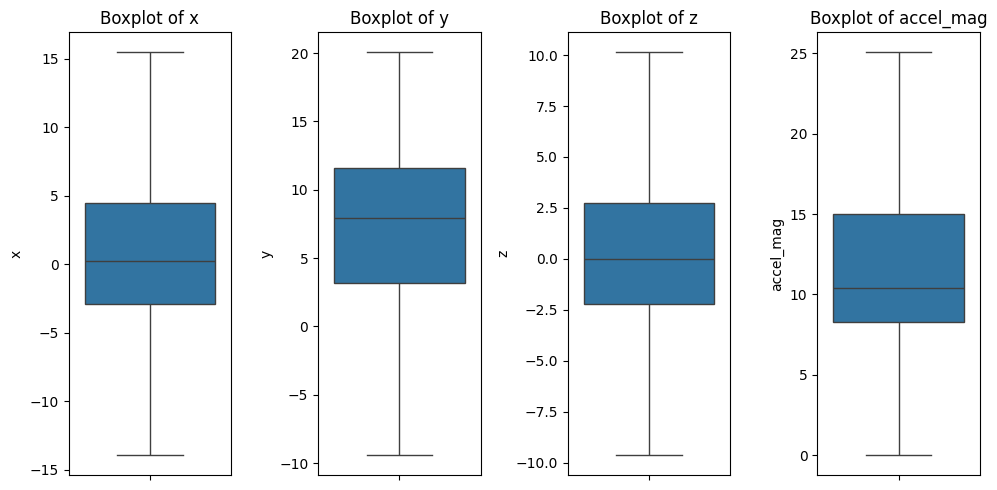

In [88]:
# Boxplots of numerical features after outlier removal
columns = ['x', 'y', 'z','accel_mag']

fig, axes = plt.subplots(1, len(columns), figsize=(10, 5))
for i, col in enumerate(columns):
    sns.boxplot(ax=axes[i], y=df[col])
    axes[i].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

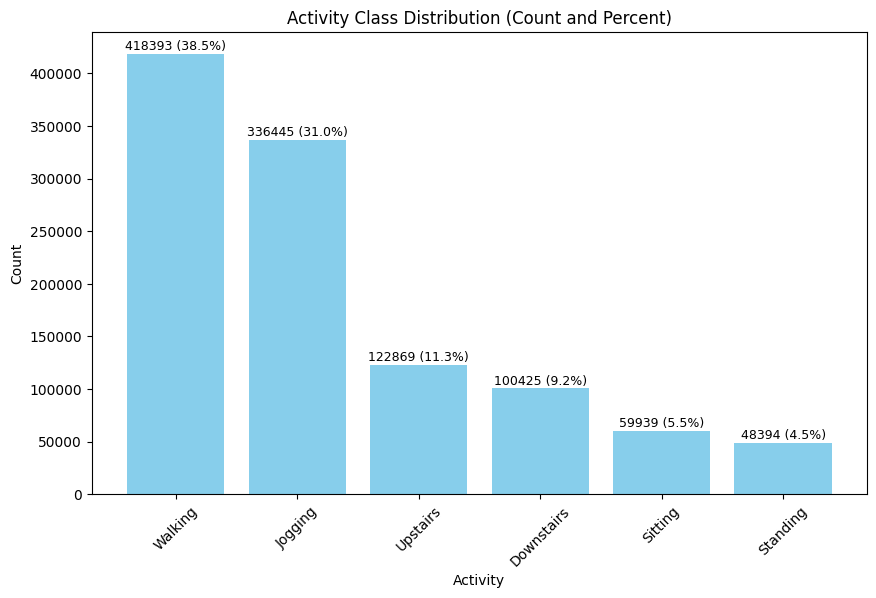

In [90]:
# Check the class distribution (counts and percentages for each activity)
activity_counts = df['activity'].value_counts()
activity_percent = df['activity'].value_counts(normalize=True) * 100

labels = [f"{count} ({percent:.1f}%)"
          for count, percent in zip( activity_counts.values, activity_percent.values)]


plt.figure(figsize=(10, 6))
bars = plt.bar(activity_counts.index, activity_counts.values, color='skyblue')

for bar, label in zip(bars, labels):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1000, label, ha='center', va='bottom', fontsize=9)

plt.title("Activity Class Distribution (Count and Percent)")
plt.xlabel("Activity")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.show()

Class distribution :

- Walking -> 418,393 -> 38.5%

- Jogging -> 336,445 -> 31%

- Upstairs -> 122,869 -> 11.3%

- Downstairs -> 100,425 -> 9.2%

- Sitting -> 59,939 -> 5.5%

- Standing -> 48,394 -> 4.5%

This Shows That there is a class imbalance this uneven distribution can lead to biased predictions where the model favors majority classes (like *Walking* and *Jogging*) and neglects the minority ones (like *Sitting* and *Standing*). This is a common issue in real-world classification tasks.

To address this imbalance, **class weights** will be computed and passed to the loss function (`CrossEntropyLoss`). This approach penalizes the model more for misclassifying underrepresented classes, encouraging it to learn better representations across all activities.

By using class weights, the model becomes more robust and fair, improving its ability to detect and classify all types of activities — especially the minority ones.

In [91]:
# Sorting using user and timestamp column
df = df.sort_values(by=['user', 'timestamp']).reset_index(drop=True)
df.head()

,user,activity,timestamp,x,y,z,accel_mag
0,1,Walking,4991922345000,0.69,10.80,-2.03,11.010767
1,1,Walking,4991972333000,6.85,7.44,-0.50,10.125517
2,1,Walking,4992022351000,0.93,5.63,-0.50,5.728159
3,1,Walking,4992072339000,-2.11,5.01,-0.69,5.479808
4,1,Walking,4992122358000,-4.59,4.29,-1.95,6.578351


In [92]:
# Normalizing numerical features in the dataset
scaler = StandardScaler()
df[['x', 'y', 'z','accel_mag']] = scaler.fit_transform(df[['x', 'y', 'z','accel_mag']])

# Label Encoding activity feature in the dataset to use for model training and classification report
le = LabelEncoder()
df['activity_encoded'] = le.fit_transform(df['activity'])

In [93]:
df.head()

,user,activity,timestamp,x,y,z,accel_mag,activity_encoded
0,1,Walking,4991922345000,-0.001640,0.535442,-0.547203,-0.131880,5
1,1,Walking,4991972333000,0.958728,0.016847,-0.199891,-0.296006,5
2,1,Walking,4992022351000,0.035777,-0.262515,-0.199891,-1.111280,5
3,1,Walking,4992072339000,-0.438171,-0.358208,-0.243022,-1.157324,5
4,1,Walking,4992122358000,-0.824813,-0.469336,-0.529043,-0.953653,5


## Preparing Data for LSTM Model

In [94]:
# Segmenting the data into sequences (Windows) suitable for LSTM input
def create_windows(df, window_size=100, step=50):
    segments = []
    labels = []
    for user in df['user'].unique():
        user_data = df[df['user'] == user]
        for i in range(0, len(user_data) - window_size, step):
            window = user_data.iloc[i:i+window_size]
            if len(window['activity_encoded'].unique()) == 1:  # Only keep windows with a single activity
                segments.append(window[['x', 'y', 'z', 'accel_mag']].values)
                labels.append(window['activity_encoded'].iloc[0])
    return np.array(segments), np.array(labels)

X_np, y_np = create_windows(df)
print(X_np.shape, y_np.shape)  # (num_samples, window_size, 4)


# Converting to PyTorch tensors
X_tensor = torch.tensor(X_np)
y_tensor = torch.tensor(y_np, dtype=torch.long)  # for CrossEntropyLoss

# Print shapes
print("X_tensor:", X_tensor.shape)
print("y_tensor:", y_tensor.shape)



(20914, 100, 4) (20914,)
X_tensor: torch.Size([20914, 100, 4])
y_tensor: torch.Size([20914])


In [96]:
from torch.utils.data import Dataset

class HAR_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X  # [num_samples, time_steps, features]
        self.y = y  # [num_samples] as class indices

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [97]:
# Spliting the dataset into training, testing and Validation sets.
from torch.utils.data import DataLoader, random_split

dataset = HAR_Dataset(X_tensor, y_tensor)

# Train/test/Validation split (60/20/20)
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [98]:
# Creating DataLoaders for efficient batch processing.
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# LSTM Model Initialization and Training

In [99]:
#LSTM Model
class HAR_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(HAR_LSTM, self).__init__()

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Forward pass
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Take the last hidden state for classification
        out = self.fc(h_n[-1])
        return out

In [100]:
# Calculate class weights based on the frequency of each class to solve class imbalance problem
class_weights = torch.tensor([1.0 / (y_np == i).sum() for i in range(len(np.unique(y_np)))], dtype=torch.float32)


input_size = 4  # x, y, z, accel_mag
hidden_size = 128
output_size = len(le.classes_)  # Number of unique activity labels
learning_rate = 0.001

model = HAR_LSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Loss function (Cross-Entropy for multi-class classification)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [101]:
# Model Training
epochs = 30

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

def compute_metrics(model, data_loader, criterion, training=True):
    running_loss = correct = total = 0
    model.train() if training else model.eval()

    with torch.set_grad_enabled(training):
        for X, y in data_loader:
            X, y = X.float(), y.long()
            outputs = model(X)
            loss = criterion(outputs, y)

            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    return running_loss / len(data_loader), correct / total

for epoch in range(epochs):
    train_loss, train_acc = compute_metrics(model, train_loader, criterion, training=True)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    val_loss, val_acc = compute_metrics(model, val_loader, criterion, training=False)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/30, Train Loss: 1.3600, Train Acc: 0.4738, Val Loss: 0.9685, Val Acc: 0.7236
Epoch 2/30, Train Loss: 1.0630, Train Acc: 0.6325, Val Loss: 0.9259, Val Acc: 0.7262
Epoch 3/30, Train Loss: 1.0526, Train Acc: 0.6493, Val Loss: 1.0861, Val Acc: 0.5925
Epoch 4/30, Train Loss: 0.9259, Train Acc: 0.6674, Val Loss: 0.7407, Val Acc: 0.7353
Epoch 5/30, Train Loss: 0.7190, Train Acc: 0.7062, Val Loss: 0.6745, Val Acc: 0.6851
Epoch 6/30, Train Loss: 0.8406, Train Acc: 0.7043, Val Loss: 0.6978, Val Acc: 0.7637
Epoch 7/30, Train Loss: 0.8353, Train Acc: 0.7120, Val Loss: 0.9023, Val Acc: 0.6052
Epoch 8/30, Train Loss: 0.7431, Train Acc: 0.6904, Val Loss: 0.9393, Val Acc: 0.6822
Epoch 9/30, Train Loss: 0.6729, Train Acc: 0.7557, Val Loss: 0.5883, Val Acc: 0.7896
Epoch 10/30, Train Loss: 0.5720, Train Acc: 0.7939, Val Loss: 0.5303, Val Acc: 0.8336
Epoch 11/30, Train Loss: 0.4998, Train Acc: 0.8194, Val Loss: 0.4715, Val Acc: 0.8728
Epoch 12/30, Train Loss: 0.4379, Train Acc: 0.8526, Val Loss: 0

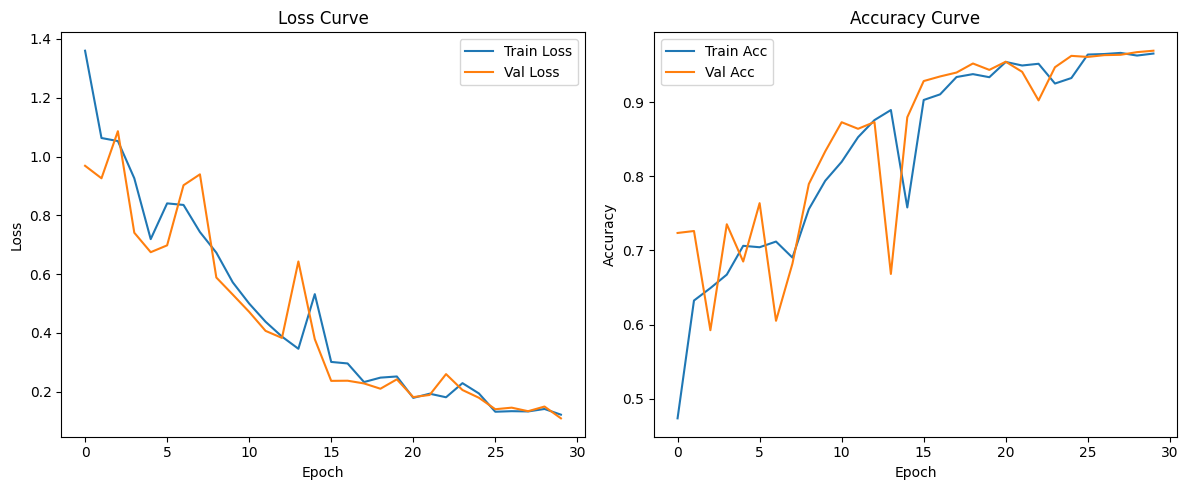

In [102]:
# plotting(Training and Validation) Loss Curve.
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# plotting (Training and Validation) Accuracy Curve.
plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluating LSTM Model Performance Using Diffrent metrics

In [103]:
# Metrics for model Evaluation
y_true = []
y_pred = []

model.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.float(), y_batch.long()

        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Precision (for multi-class classification)
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.2f}")

# Recall (for multi-class classification)
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall:.2f}")

# F1-Score (for multi-class classification)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1-Score: {f1:.2f}")

Accuracy: 96.73%
Precision: 0.97
Recall: 0.97
F1-Score: 0.97


In [104]:
# Showing Predicted Vs Actual samples
model.eval()
with torch.no_grad():
    for X_part, y_part in test_loader:
        X_part = X_part.float()
        logits = model(X_part)
        probabilities = torch.softmax(logits, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        print("Predicted classes:", predicted_classes)
        print("Actual classes:   ", y_part)
        break

Predicted classes: tensor([5, 5, 0, 4, 1, 1, 1, 5, 1, 1, 3, 5, 1, 3, 1, 0, 4, 5, 1, 5, 5, 0, 5, 4,
        1, 4, 5, 5, 5, 0, 1, 4, 2, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 1, 5, 1, 1, 1,
        1, 5, 2, 1, 5, 5, 1, 1, 2, 1, 5, 5, 1, 2, 5, 4])
Actual classes:    tensor([5, 5, 4, 4, 1, 1, 0, 5, 1, 1, 3, 5, 1, 3, 1, 0, 4, 5, 1, 5, 5, 0, 5, 4,
        1, 4, 5, 5, 5, 0, 1, 4, 2, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 1, 5, 1, 1, 1,
        1, 5, 2, 1, 5, 5, 1, 1, 2, 1, 5, 5, 1, 2, 5, 4])


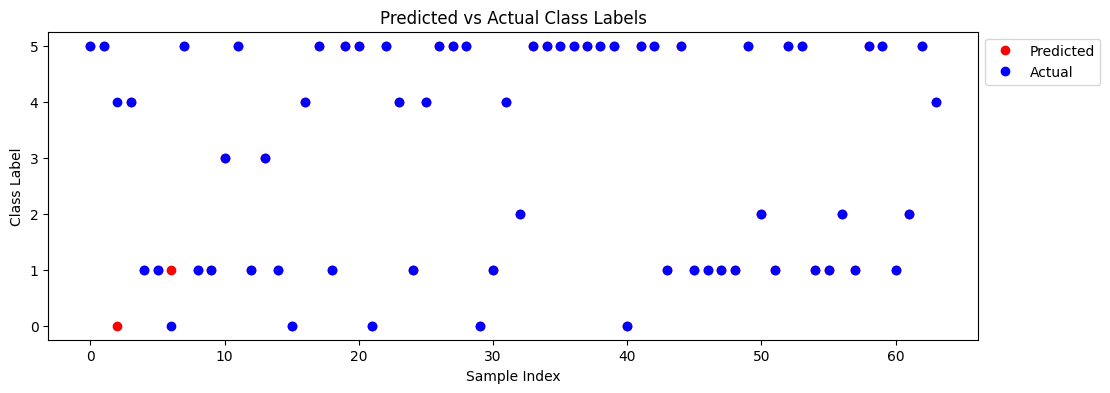

In [116]:
# Visualization: Bar plot for all samples in the batch comparing actual vs predicted samples
n_samples = 64
plt.figure(figsize=(12, 4))
plt.plot(range(n_samples), predicted_classes[:n_samples], 'ro', label='Predicted')
plt.plot(range(n_samples), y_part[:n_samples], 'bo', label='Actual')
plt.xlabel('Sample Index')
plt.ylabel('Class Label')
plt.title('Predicted vs Actual Class Labels')
plt.legend(bbox_to_anchor=(1, 1),loc='upper left')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       349
           1       1.00      0.97      0.99      1337
           2       1.00      0.95      0.97       246
           3       0.94      1.00      0.97       182
           4       0.90      0.95      0.93       430
           5       0.99      0.97      0.98      1640

    accuracy                           0.97      4184
   macro avg       0.95      0.97      0.96      4184
weighted avg       0.97      0.97      0.97      4184



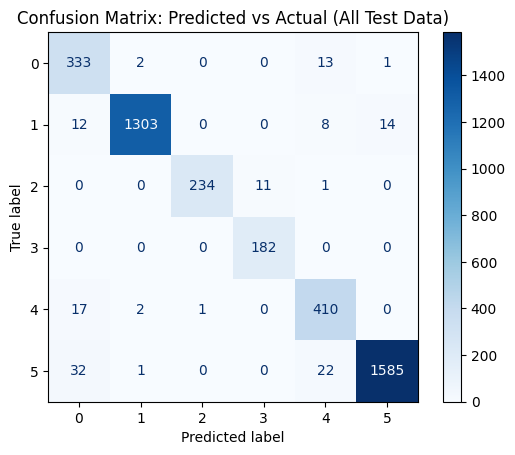

In [118]:
# Classification report and Confusion Matrix.
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for X_part, y_part in test_loader:
        X_part = X_part.float()
        logits = model(X_part)
        probabilities = torch.softmax(logits, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        all_preds.extend(predicted_classes.cpu().numpy())
        all_labels.extend(y_part.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Predicted vs Actual (All Test Data)")
plt.show()

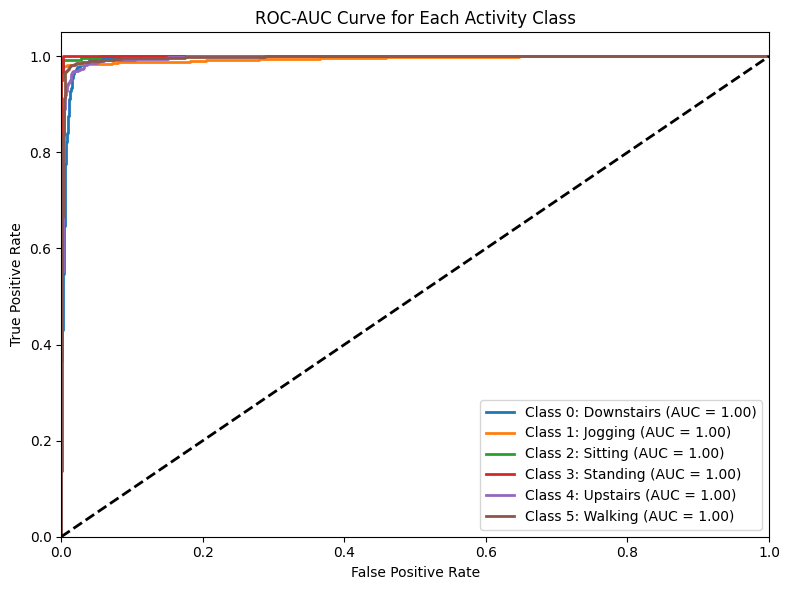

In [107]:
# ROC-AUC Curve for Each Activity Class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for X_part, y_part in test_loader:
        X_part = X_part.float()
        logits = model(X_part)
        probs = torch.softmax(logits, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_labels.extend(y_part.cpu().numpy())

all_probs = np.vstack(all_probs)
all_labels = np.array(all_labels)

# Binarize the labels for multi-class ROC
n_classes = len(le.classes_)
y_test_bin = label_binarize(all_labels, classes=np.arange(n_classes))

# Plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i}: {le.inverse_transform([i])[0]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Each Activity Class')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# Using  t-SNE to project the LSTM's hidden states into 2D for visualization of class separability.

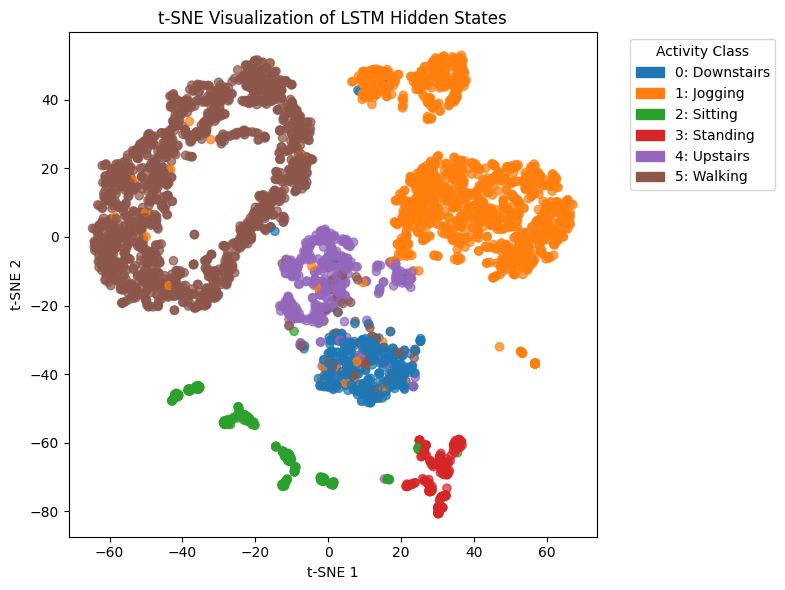

In [109]:
# t-SNE Visualization

from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

# Collect last hidden states and labels
all_hidden, all_labels = [], []
model.eval()
with torch.no_grad():
    for X_part, y_part in test_loader:
        X_part = X_part.float()
        last_hidden = model.lstm(X_part)[1][0][-1]
        all_hidden.append(last_hidden.cpu().numpy())
        all_labels.extend(y_part.cpu().numpy())
all_hidden = np.vstack(all_hidden)
all_labels = np.array(all_labels)


hidden_tsne = TSNE(n_components=2, random_state=42).fit_transform(all_hidden)

class_names = le.inverse_transform(np.arange(len(le.classes_)))
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.figure(figsize=(8, 6))
plt.scatter(hidden_tsne[:, 0], hidden_tsne[:, 1], c=[custom_colors[label] for label in all_labels], alpha=0.7)
plt.title('t-SNE Visualization of LSTM Hidden States')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
handles = [mpatches.Patch(color=custom_colors[i], label=f"{i}: {class_names[i]}") for i in range(len(class_names))]
plt.legend(handles=handles, title="Activity Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()